## RAG implementation
#### in this notebook we will briefly compare RAG enriched LLM and basic LLM

In [19]:
import os
from dotenv import load_dotenv
import openai
import chromadb
import tiktoken
import sqlite3
import nltk
from nltk.tokenize import word_tokenize
from rank_bm25 import BM25Okapi
from sentence_transformers import CrossEncoder
import time
import functools
import matplotlib.pyplot as plt
import pickle

In [20]:
load_dotenv()

True

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kacpe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kacpe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [22]:
OPEN_AI_API_KEY = os.getenv("OPENAI_API_KEY")
CHROMA_DB_PATH = "./../data_collecting/chroma_db"

In [23]:
chat_model = "gpt-4o-mini"

In [24]:
python_versions=["3.10","3.11","3.12","3.13"]

In [41]:
bm25_per_python_version = {"3.10": None, "3.11": None, "3.12": None, "3.13": None }

In [134]:
def format_query(user_query):
    if "python" not in user_query.lower():
        return f"{user_query} in Python"
    return user_query

In [165]:
prompt_model = """
    ### Context:
    {context}
    
    ### User's questions:
    {query}

    ### Python version: 
    {python_version}
    
    ** Instructions **
    - If user asks you to generate code and by using context you cannot do it, then generate it on your own
    - If user doesn't ask to generate code and the context does not contain answer for query say "I don't have sufficient knowledge to answer this question".
    - If the user's question does not specify Python, rephrase it internally as a Python-related question before answering.
    - If there is a code in your output explain this code to the user step by step
    - Do not answer any other question than about python programming language
    - If topic is complex provide summary at the end of your answer
    - Do not make up any information
    - Provide consise and structured answer
    """


### Preparing bm25 to serialize

In [42]:
conn = sqlite3.connect("../data_collecting/documents.db")
cursor = conn.cursor()

for python_version in python_versions:

    cursor.execute("SELECT id, document FROM documents WHERE id LIKE ?", (f"{python_version}%",))
    rows = cursor.fetchall()
    
    ids = [row[0] for row in rows]
    documents = [row[1] for row in rows]

    tokenized_documents = [word_tokenize(doc.lower()) for doc in documents]
    bm25 = BM25Okapi(tokenized_documents)

    bm25_per_python_version[python_version] = bm25

conn.close()

In [47]:
with open("bm25_per_python_version.pkl", "wb") as f:
    pickle.dump(bm25_per_python_version, f)

In [48]:
with open("bm25_per_python_version.pkl", "rb") as f:
    bm25_per_python_version = pickle.load(f)

In [25]:
client = chromadb.PersistentClient(path=CHROMA_DB_PATH)
collection = client.get_or_create_collection(name="python_data")

In [26]:
openai.api_key = OPEN_AI_API_KEY 

In [109]:
def get_openai_embedding(text):
    response = openai.embeddings.create(
        input=[text],
        model="text-embedding-ada-002"
    )
    return response.data[0].embedding

def retrieve_documents(query, python_version, top_k=7):
    query_embedding = get_openai_embedding(query)

    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k,
        where={"version": python_version}
    )

    return results["documents"][0] if "documents" in results and results["documents"] else []

def generate_response(query, retrieved_docs, python_version):
    context = "\n\n".join(retrieved_docs)
    
    prompt = prompt_model.format(context = context,query = query,python_version = python_version)
    client = openai.Client()
    response = client.chat.completions.create(
        model=chat_model,
        temperature=0.3,
        messages=[{"role": "system", "content": "You are python expert and you provide answer only based on given context."},
                  {"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [ ]:
query = "Jak działa match-case w Pythonie 3.10?"
retrieved_docs = retrieve_documents(query, "3.10", 5)
answer = generate_response(query, retrieved_docs, "3.10")


In [ ]:
print(answer)

In [ ]:
example_queries = ["what is match-case?", "How multiinheritance in python works?", "What is SyntaxError?" ]

In [ ]:
answers = []

In [ ]:
for query in example_queries:
    python_version = "3.10"
    retrieved_docs = retrieve_documents(query, python_version, 3)
    answer_rag = generate_response(query, retrieved_docs, python_version)

    client = openai.Client()
    response = client.chat.completions.create(
        model="gpt-4-turbo",
        messages=[{"role": "system", "content": "You are python expert and you provide answer only based on given context."},
                  {"role": "user", "content": query + " python version is: " + python_version}]
    )

    normal_answer = response.choices[0].message.content

    answers.append({"rag": answer_rag, "normal": normal_answer})

In [ ]:

for answer in answers:
    print("-"*90)
    print("1: " + answer["rag"])
    print("2: " + answer["normal"])

In [ ]:
for query in example_queries:
    retrieved_docs = retrieve_documents(query, "3.10", 7)
    answer = generate_response(query, retrieved_docs, "3.10")

    print("-"*50)
    print("QUESTION: " + query)
    print("ANSWER: " + answer)
    

## BM25 + RERANK + VECTOR SEARCH

In [30]:
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [141]:
def search_in_sqlite(query, python_version, top_k=5):
    bm25 = bm25_per_python_version[python_version]

    tokenized_query = word_tokenize(query.lower())
    scores = bm25.get_scores(tokenized_query)
    
    top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_k]
    
    return [documents[i] for i in top_indices]

def retrieve_documents_bm25(query, python_version, top_k=5):
    query_embedding = get_openai_embedding(query)

    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k,
        where={"version": python_version}
    )

    embedding_results = results["documents"][0] if "documents" in results and results["documents"] else []
    
    bm25_results = search_in_sqlite(query, python_version, top_k)

    combined_results = list(set(embedding_results + bm25_results))

    return combined_results

def rerank_results(query, retrieved_docs, top_k=7):
    if not retrieved_docs:
        return []

    pairs = [(query, doc) for doc in retrieved_docs]
    scores = reranker.predict(pairs)
    
    ranked_results = sorted(zip(retrieved_docs, scores), key=lambda x: x[1], reverse=True)

    return [doc for doc, _ in ranked_results[:top_k]]

def generate_response_bm25_rerank(query, retrieved_docs, python_version):
    reranked_docs = rerank_results(query, retrieved_docs)

    context = "\n\n".join(reranked_docs)
    
    prompt = prompt_model.format(context = context,query = query,python_version = python_version)
    # print(prompt)

    client = openai.Client()
    response = client.chat.completions.create(
        model=chat_model,
        temperature=0.3,
        messages=[{"role": "system", "content": "You are a Python expert and you provide answers only based on the given context."},
                  {"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

## BM25 + VECTOR SEARCH

In [112]:
def retrieve_documents_bm25_only(query, python_version, top_k=5):
    query_embedding = get_openai_embedding(query)

    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k,
        where={"version": python_version}
    )

    embedding_results = results["documents"][0] if "documents" in results and results["documents"] else []
    
    bm25_results = search_in_sqlite(query, python_version, top_k)

    combined_results = list(set(embedding_results + bm25_results))

    return combined_results

def generate_response_bm25(query, retrieved_docs, python_version):
    context = "\n\n".join(retrieved_docs)
    
    prompt = prompt_model.format(context = context,query = query,python_version = python_version)

    client = openai.Client()
    response = client.chat.completions.create(
        model=chat_model,
        temperature=0.3,
        messages=[{"role": "system", "content": "You are a Python expert and you provide answers only based on the given context."},
                  {"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

## RERANK + VECTOR SEARCH

In [113]:
def generate_response_rerank(query, retrieved_docs, python_version):
    reranked_docs = rerank_results(query, retrieved_docs, 10)

    context = "\n\n".join(reranked_docs)
    
    prompt = prompt_model.format(context = context,query = query,python_version = python_version)

    client = openai.Client()
    response = client.chat.completions.create(
        model=chat_model,
        temperature=0.3,
        messages=[{"role": "system", "content": "You are a Python expert and you provide answers only based on the given context."},
                  {"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [ ]:
query = "Jak otworzyć plik CSV w Pythonie?"
python_version = "3.10"

retrieved_docs = retrieve_documents_bm25(query, python_version, top_k=10)
response = generate_response_bm25_rerank(query, retrieved_docs, python_version)

In [50]:
query = "How can i read content from file?"
python_version = "3.10"

In [51]:
speed_test = {"vector": [], "bm25": [], "rerank": [], "bm25rerank": []}

In [ ]:
start_time = time.time()
retrieved_docs = retrieve_documents_bm25(query, python_version, top_k=5)
response = generate_response_bm25_rerank(query, retrieved_docs, python_version) 
end_time = time.time()
execution_time = end_time - start_time
print("execution_time :", execution_time)

In [ ]:
retrieved_docs = retrieve_documents(query, "3.10", 3)

In [60]:
minIterations = 8
maxIterations = 15

In [61]:
for i in range(minIterations, maxIterations):
    start_time = time.time()
    retrieved_docs = retrieve_documents_bm25(query, python_version, top_k=i)
    response = generate_response_bm25_rerank(query, retrieved_docs, python_version) 
    end_time = time.time()
    execution_time = end_time - start_time
    speed_test["bm25rerank"].append({"numberDoc": i, "response": response, "time": execution_time})
    print(i,end="")

891011121314

In [62]:
for i in range(minIterations, maxIterations):
    start_time = time.time()
    retrieved_docs = retrieve_documents_bm25_only(query, python_version, top_k=i)
    response = generate_response_bm25(query, retrieved_docs, python_version) 
    end_time = time.time()
    execution_time = end_time - start_time
    speed_test["bm25"].append({"numberDoc": i, "response": response, "time": execution_time})
    print(i,end="")

891011121314

In [63]:
for i in range(minIterations, maxIterations):
    start_time = time.time()
    retrieved_docs = retrieve_documents(query, "3.10", i)
    answer = generate_response(query, retrieved_docs, "3.10")
    end_time = time.time()
    execution_time = end_time - start_time
    speed_test["vector"].append({"numberDoc": i, "response": response, "time": execution_time})
    print(i,end="")

891011121314

In [64]:
for i in range(minIterations, maxIterations):
    start_time = time.time()
    retrieved_docs = retrieve_documents(query, "3.10", i)
    answer = generate_response_rerank(query, retrieved_docs, "3.10")
    end_time = time.time()
    execution_time = end_time - start_time
    speed_test["rerank"].append({"numberDoc": i, "response": response, "time": execution_time})
    print(i,end="")

891011121314

In [ ]:
def measure_time(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        execution_time = end_time - start_time
        print(f"{func.__name__} finished in {execution_time:.4f} seconds.")
        return result
    return wrapper

In [56]:
with open("speed_test.pkl", "wb") as f:
    pickle.dump(speed_test, f)

In [ ]:
speed_test_copy = list(speed_test)

In [ ]:
print(speed_test)

In [3]:
with open("speed_test.pkl", "rb") as f:
    speed_test = pickle.load(f)



In [58]:


def generate_speed_test_plot(speed_test):
    plt.figure(figsize=(10, 6))

    for model, data in speed_test.items():
        if data:
            x_values = [entry["numberDoc"] for entry in data] 
            y_values = [entry["time"] for entry in data] 
            plt.plot(x_values, y_values, label=model, marker='o', linestyle='-')

    plt.xlabel("Number of Documents")
    plt.ylabel("Execution Time (seconds)")
    plt.title("Execution Time vs Number of Documents for Different Models")
    plt.legend()
    plt.grid(True)
    plt.show()




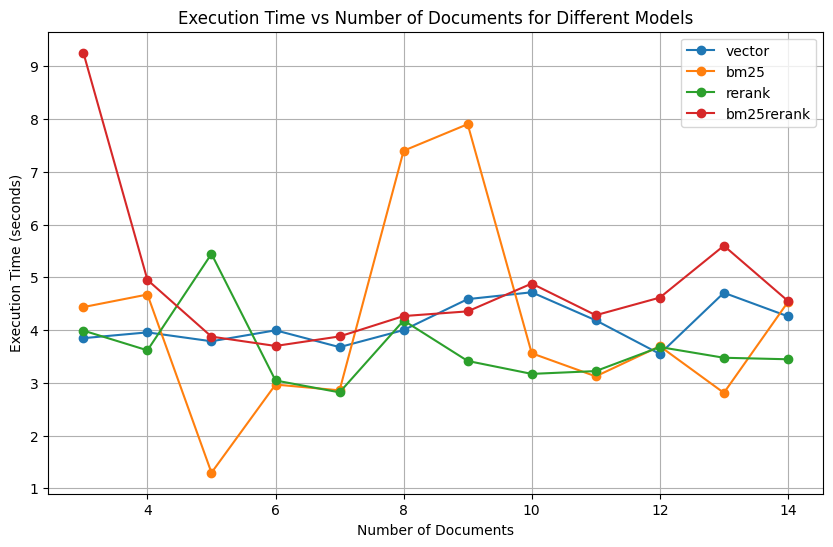

In [65]:
generate_speed_test_plot(speed_test)

In [142]:
def generate_answer(type_model, query, python_version, num_docs):
    query = format_query(query)
    match type_model:
        case "vector":
            retrieved_docs = retrieve_documents(query, python_version, num_docs)
            return generate_response(query, retrieved_docs, python_version)
        case "bm25":
            retrieved_docs = retrieve_documents_bm25_only(query, python_version, num_docs)
            return generate_response_bm25(query, retrieved_docs, python_version) 
        case "rerank":
            retrieved_docs = retrieve_documents(query, python_version, num_docs)
            return generate_response_rerank(query, retrieved_docs, python_version)
        case "bm25rerank":
            retrieved_docs = retrieve_documents_bm25(query, python_version, top_k=num_docs)
            return generate_response_bm25_rerank(query, retrieved_docs, python_version) 

In [ ]:
speed_test = {"vector": [], "bm25": [], "rerank": [], "bm25rerank": []}

In [68]:
print(speed_test["vector"][6]["response"])
print(100*"-")
print(speed_test["bm25"][6]["response"])
print(100*"-")
print(speed_test["rerank"][6]["response"])
print(100*"-")
print(speed_test["bm25rerank"][6]["response"])

To read content from a file in Python, you can use the built-in `open` function along with the `read` method. Here’s a simple example:

```python
with open('your_file.txt', 'r') as f:
    content = f.read()
    print(content)
```

This code snippet does the following:
- Opens the file `your_file.txt` in read mode (`'r'`).
- Reads the entire content of the file into the variable `content`.
- Prints the content to the console.

Make sure to replace `'your_file.txt'` with the path to your actual file.
----------------------------------------------------------------------------------------------------
To read content from a file in Python, you can use the `gzip` module if the file is compressed. Here’s an example of how to read a compressed GZIP file:

```python
import gzip

with gzip.open('/home/joe/file.txt.gz', 'rb') as f:
    file_content = f.read()
```

If you want to read a regular text file, you can use the built-in `open` function:

```python
with open('path/to/your/file.txt', 'r')

In [153]:
print("dwadwada

SyntaxError: unterminated string literal (detected at line 1) (1678533775.py, line 1)

In [166]:
print(generate_answer("bm25rerank", "Generate me code to open file", "3.10", 10))

Here is a simple code snippet to open a file in Python:

```python
filename = 'example.txt'  # Specify the name of the file you want to open
with open(filename, 'r') as file:  # Open the file in read mode
    content = file.read()  # Read the content of the file
    print(content)  # Print the content to the console
```

### Explanation:
1. **Specify the Filename**: The variable `filename` is assigned the name of the file you want to open (in this case, 'example.txt').
2. **Open the File**: The `with open(filename, 'r') as file:` statement opens the file in read mode (`'r'`). The `with` statement ensures that the file is properly closed after its suite finishes, even if an error is raised.
3. **Read the Content**: The `file.read()` method reads the entire content of the file and stores it in the variable `content`.
4. **Print the Content**: Finally, `print(content)` outputs the content of the file to the console.

### Summary:
This code demonstrates how to open a file, read its content